In [3]:
import logging
import pandas as pd
import numpy as np
import gensim
import nltk
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn import linear_model
import re
import json
import glob

from gensim.models import Word2Vec
import multiprocessing
from nltk.stem import WordNetLemmatizer 

%matplotlib inline

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/iso-2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/iso-2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iso-2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

No. of unique classes:  30


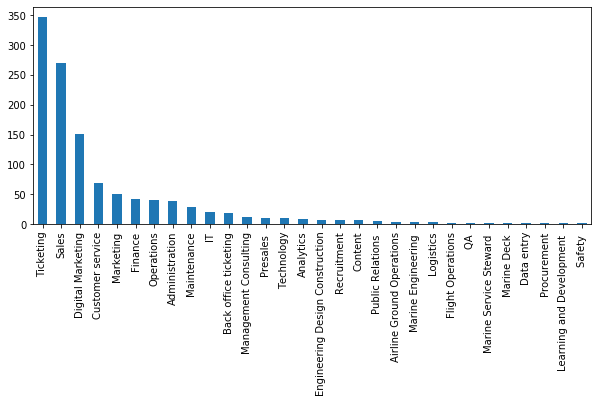

In [4]:
dep_df = pd.read_csv('data/document_departments.csv')

departments = dep_df.Department.unique()
print('No. of unique classes: ', len(departments))

plt.figure(figsize=(10,4))
dep_df['Department'].value_counts().plot(kind='bar');

The classes are not well balanced

In [12]:
list1 = []

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

for i in glob.glob('data/docs/*.json'):
    file = json.load(open(i))
    desc = file['jd_information']['description']
    desc = REPLACE_BY_SPACE_RE.sub(' ', desc)
#     desc = BAD_SYMBOLS_RE.sub(' ', desc)
    desc = desc.split()
                    
    list1.append([int(file['_id']), file['jd_information']['description'], desc])
    
desc_df = pd.DataFrame(list1, columns=['Document ID', 'Description', 'Filtered'])

In [13]:
df = pd.merge(dep_df, desc_df, left_on='Document ID', right_on='Document ID')
df.head()

,Document ID,Department,Description,Filtered
0,8196431,Customer service,Designation- TeleMarketing ExecutiveKeyskills-...,"[Designation-, TeleMarketing, ExecutiveKeyskil..."
1,8278123,Digital Marketing,We need committed &amp; result-oriented people...,"[We, need, committed, &amp, result-oriented, p..."
2,8331625,Sales,Greetings from Akkam Immigrations!!!Immediate ...,"[Greetings, from, Akkam, Immigrations!!!Immedi..."
3,8331003,Back office ticketing,"Dear Candidates,Greetings From Continental Imm...","[Dear, Candidates, Greetings, From, Continenta..."
4,8277939,Digital Marketing,We need committed &amp; result-oriented people...,"[We, need, committed, &amp, result-oriented, p..."


In [21]:
# Train/test split of 90/10
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

print('Training data: ', len(train_data), 'Test data: ', len(test_data))

Training data:  1045 Test data:  117


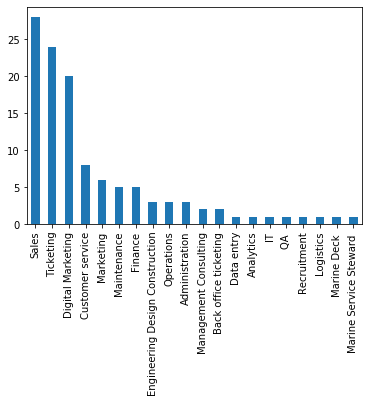

In [16]:
test_data['Department'].value_counts().plot(kind='bar');

In [64]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(departments))
    target_names = departments
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.figure(figsize=(10,10))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=departments)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [39]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['Description'])
    predictions = classifier.predict(data_features)
    target = data['Department']
    evaluate_prediction(predictions, target)

In [18]:
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [28]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [29]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [30]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['Description']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['Description']), axis=1).values

In [33]:
%%time
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  


CPU times: user 1.11 s, sys: 469 ms, total: 1.58 s
Wall time: 1.31 s


In [36]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['Department'])
predicted = logreg.predict(X_test_word_average)

/home/iso-2/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/iso-2/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 3.67 s, sys: 15.6 ms, total: 3.69 s
Wall time: 3.81 s


55.55555555555556
accuracy 0.5555555555555556
confusion matrix
 [[ 5  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 16  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 2  0 21  0  2  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  8  0 13  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  2  0  1  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  3  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  1  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


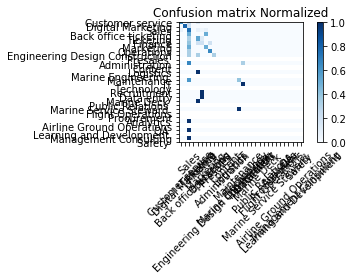

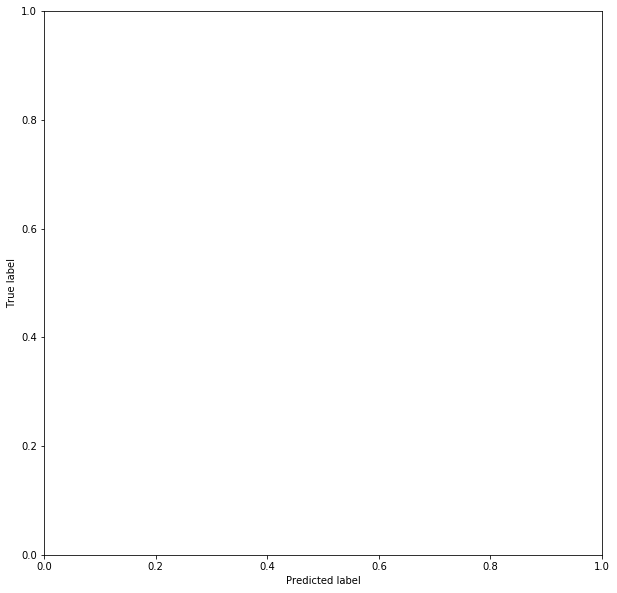

In [65]:
test_list = 0
for i in range(len(predicted)):
    if predicted[i] == test_data.Department.values[i]:
        test_list += 1

print(test_list/len(predicted)*100)

evaluate_prediction(predicted, test_data.Department)